## Setup : Sampling from image dataset and retrieving captions

In [307]:
from PIL import Image
import itertools, random
import glob,os, json
import random,shutil
from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


In [314]:
def get_trainfiles(target_folder, n_samples):
    all_files=glob.glob("train2014/*.jpg")
    train_files = []
    print("Getting number of samples: ",n_samples)
    for image in random.sample(all_files,n_samples):
      train_files.append(image)
      shutil.move(image, target_folder)
    train_files = [a.split('\\')[1] for a in train_files]
    print("Moved sampled images to {}".format(target_folder))
    return train_files
    

In [321]:
def get_captions():
    with open('dataset_coco.json') as file:
        data = json.load(file)
    captions = {}
    ids = {}
#     pprint(data['images'][0])
    for item in data['images']:
        if len(ids)==len(train_files):
            break
        if item['filename'] in train_files:
            ids['filename'] = item['imgid']
            captions[item['filename']] = [caption['raw'] for caption in item['sentences']]  
    
    all_captions = []
    all_captions.extend(itertools.chain(*(value for key,value in captions.items())))
    print("Retrieved captions for sampled images.")
    return captions, all_captions

In [323]:
train_files = get_trainfiles("trainfolder/",1000)
captions, all_captions = get_captions()

Getting number of samples:  1000
Moved sampled images to trainfolder/
Retrieved captions for sampled images.


### Example from sampled training set

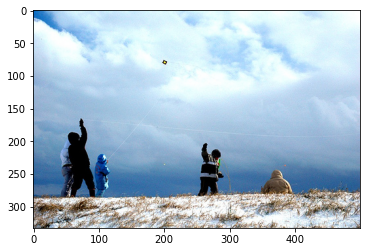

trainfolder/COCO_train2014_000000195877.jpg
['a number of people on a hill with a kite in the sky',
 'Several people in winter coats, standing together on a snow covered hill '
 'area and flying a kite in the sky.',
 'Group of people gathered around a child playing with a kite.',
 'A group of people that are standing outside flying kites.',
 'a group of people flying kites in the sky.']


In [325]:
image_path = "trainfolder/" + random.choice(list(captions.keys()))
img=mpimg.imread(image_path)
imgplot = plt.imshow(img)
plt.show()
print(image_path)
pprint(captions[image_path.split('/')[1]][0:])


# Bias Analysis

### Identifying gender nouns, their associated verbs 

CC coordinating conjunction <br>
CD cardinal digit<br>
DT determiner<br>
EX existential there (like: “there is” … think of it like “there exists”)<br>
FW foreign word<br>
IN preposition/subordinating conjunction<br>
JJ adjective ‘big’<br>
JJR adjective, comparative ‘bigger’<br>
JJS adjective, superlative ‘biggest’<br>
LS list marker 1)<br>
MD modal could, will<br>
NN noun, singular ‘desk’<br>
NNS noun plural ‘desks’<br>
NNP proper noun, singular ‘Harrison’<br>
NNPS proper noun, plural ‘Americans’<br>
PDT predeterminer ‘all the kids’<br>
POS possessive ending parent’s<br>
PRP personal pronoun I, he, she<br>
PRP\$ possessive pronoun my, his, hers<br>
RB adverb very, silently,<br>
RBR adverb, comparative better<br>
RBS adverb, superlative best<br>
RP particle give up<br>
TO, to go ‘to’ the store.<br>
UH interjection, errrrrrrrm<br>
VB verb, base form take<br>
VBD verb, past tense took<br>
VBG verb, gerund/present participle taking<br>
VBN verb, past participle taken<br>
VBP verb, sing. present, non-3d take<br>
VBZ verb, 3rd person sing. present takes<br>
WDT wh-determiner which<br>
WP wh-pronoun who, what<br>
WP$ possessive wh-pronoun whose<br>
WRB wh-abverb where, when<br>

### Define gender nouns, pronouns (expand/reduce lists as required)

In [345]:
import nltk
from nltk import word_tokenize, pos_tag
from collections import defaultdict

# nltk.download('averaged_perceptron_tagger')
# nltk.download('punkt')

gender_nouns = ['man','woman','person','boy','girl','men','women','someone',
                'lady','boys','girls','gentleman','ladies','gentlemen','person','people',
                'child','pedestrian','guy','male','female',
               'passenger']
gender_pronouns = ['his','he','hers','her''she','its','it']
verb_tags = ['VBG','VBD','VBN','VB']
adj_tags = ['JJ','JJR','JJS']
noun_tags = ['NN','NNS','NNP','NNPS']


In [349]:
def get_tag_dicts(get_tags):
    gender_verbs_dict = defaultdict(list)
    pronoun_verbs_dict = defaultdict(list)
#     print(pronoun_verbs_dict)
    # gender_verbs_dict = dict.fromkeys(gender_nouns, [])
    # pronoun_verbs_dict = dict.fromkeys(gender_pronouns, [])

    for caption in all_captions:
        # verbs : VBG, VBD, VBN
        tokens = word_tokenize(caption)

        if any(nn in tokens for nn in gender_nouns) or any(pn in tokens for pn in gender_pronouns):
            tags = pos_tag(tokens)

            only_tags = [tag[1] for tag in tags]
            if any(verb_tag in only_tags for verb_tag in get_tags):
                only_verbs = [tag[0] for tag in tags if tag[1] in get_tags]
                if set(gender_nouns).intersection(tokens):   

                    for nn in set(gender_nouns).intersection(tokens):

                        gender_verbs_dict[nn].extend(only_verbs)

                if set(gender_pronouns).intersection(tokens):
                    for pn in set(gender_pronouns).intersection(tokens):
    #                     print(pn, pronoun_verbs_dict[pn])
                        pronoun_verbs_dict[pn].extend(only_verbs)
    
    return gender_verbs_dict, pronoun_verbs_dict

### lists of words associated with gender nouns and pronouns

In [429]:
gender_dict, pronoun_dict = get_tag_dicts(verb_tags)  
gender_count,pronoun_count = {},{}  

### Most frequent items (verbs/adj/nouns) associated with each gender noun/pronoun

In [430]:
def top_n_items(nn,pos):
    
    corresp_tags = {'adj': adj_tags, 'verb':verb_tags, 'noun':noun_tags}
    gender_dict, pronoun_dict = get_tag_dicts(corresp_tags[pos])  
    gender_count,pronoun_count = {},{}
    
    for (key1, value1) in gender_dict.items():
        gender_count[key1] = set([(i,value1.count(i)) for i in value1])
    for (key2, value2) in pronoun_dict.items():   
        pronoun_count[key2] = set([(i,value2.count(i)) for i in value2])     
    
    count = 15
    dictionary = gender_count if nn in gender_nouns else pronoun_count
    return sorted(dict(dictionary[nn]), key = dict(dictionary[nn]).get, reverse=True)[:count]

In [431]:
top_n_items('woman','verb')

['holding',
 'sitting',
 'standing',
 'walking',
 'playing',
 'looking',
 'talking',
 'carrying',
 'riding',
 'cutting',
 'wearing',
 'flying',
 'jumping',
 'using',
 'smiling']

In [422]:
top_n_items('man','verb')

['holding',
 'standing',
 'wearing',
 'riding',
 'sitting',
 'walking',
 'playing',
 'taking',
 'looking',
 'eating',
 'using',
 'flying',
 'talking',
 'carrying',
 'doing']

In [432]:
all_count = {}
pro_all_count = {}

for item1,item2 in zip(gender_count, pronoun_count):
    all_count[item1] = {each[0]:each[1] for each in gender_count[item1]}
    pro_all_count[item2]= {each[0]:each[1] for each in pronoun_count[item2]}
    

### Calculating the Gender bias (if any) in training set

In [280]:
male = 'man'
female = 'woman'
# data : gender nouns or pronouns : all_count or pro_all_count
data = all_count.copy()
dictionary = set([a for key,values in data.items() for a in values if key==male or key==female])
print(pro_all_count)

{'his': {'faced': 1, 'preparing': 2, 'having': 1, 'poking': 1, 'walking': 1, 'eating': 2, 'mounting': 1, 'winding': 1, 'bending': 1, 'using': 1, 'trying': 1, 'hiding': 2, 'herding': 1, 'loading': 1, 'grabs': 1, 'knot': 1, 'watching': 1, 'pitching': 1, 'warming': 1, 'dressing': 1, 'flying': 1, 'throwing': 1, 'holding': 9, 'touching': 1, 'eying': 1, 'laying': 1, 'taken': 1, 'swinging': 3, 'covered': 2, 'jumping': 2, 'cutting': 1, 'wearing': 5, 'hit': 1, 'balancing': 1, 'showing': 1, 'playing': 3, 'skateboarding': 2, 'impending': 1, 'posing': 1, 'getting': 1, 'sitting': 7, 'sticking': 2, 'tending': 1, 'standing': 6, 'talking': 1, 'riding': 6, 'crossed': 3, 'parking': 1, 'looking': 5, 'helping': 1}, 'it': {'racing': 1, 'feeding': 1, 'attacked': 1, 'reading': 1, 'growing': 1, 'boiled': 1, 'sniffing': 1, 'made': 2, 'sitting': 11, 'primafrio': 1, 'engraved': 1, 'washing': 1, 'attached': 1, 'flanking': 1, 'cut': 1, 'playing': 1, 'cutting': 3, 'winding': 1, 'bending': 1, 'including': 1, 'prepar

In [281]:
bias_dict_men,bias_dict_women = {}, {}
for word in dictionary:
    man_count = data[male].get(word,0)
    woman_count = data[female].get(word,0)
    if man_count!=0 and woman_count!=0: bias_dict_men[word] = man_count/(man_count+woman_count)
    if woman_count!=0 and man_count!=0: bias_dict_women[word] = woman_count/(man_count+woman_count)

In [287]:
for i in sorted(bias_dict_men, key=bias_dict_men.get,reverse=False):
    print(i,bias_dict_men[i],data[male][i])

eating 0.2857142857142857 2
smiling 0.2857142857142857 2
using 0.3333333333333333 2
watching 0.3333333333333333 1
cutting 0.4 2
posing 0.4444444444444444 4
carrying 0.5 2
putting 0.5 2
decorated 0.5 1
catching 0.5 1
holding 0.5084745762711864 30
laying 0.5333333333333333 8
preparing 0.6 3
sitting 0.6 21
standing 0.631578947368421 36
trying 0.6666666666666666 2
skiing 0.6666666666666666 2
having 0.6666666666666666 2
playing 0.7058823529411765 12
dressed 0.7142857142857143 5
looking 0.75 12
reading 0.75 3
swinging 0.8 8
walking 0.8235294117647058 14
riding 0.8333333333333334 45
covered 0.8888888888888888 8


Men: riding, walking, swinging, reading, dressed, playing, skiing, trying, standing, sitting, preparing, laying, holding <br>
Women: smiling, eating,(also) watching, using, cutting, posing

In [288]:
for i in sorted(bias_dict_women, key=bias_dict_women.get,reverse=False):
    print(i,bias_dict_women[i],data[female][i])

covered 0.1111111111111111 1
riding 0.16666666666666666 9
walking 0.17647058823529413 3
swinging 0.2 2
looking 0.25 4
reading 0.25 1
dressed 0.2857142857142857 2
playing 0.29411764705882354 5
trying 0.3333333333333333 1
skiing 0.3333333333333333 1
having 0.3333333333333333 1
standing 0.3684210526315789 21
preparing 0.4 2
sitting 0.4 14
laying 0.4666666666666667 7
holding 0.4915254237288136 29
carrying 0.5 2
putting 0.5 2
decorated 0.5 1
catching 0.5 1
posing 0.5555555555555556 5
cutting 0.6 3
using 0.6666666666666666 4
watching 0.6666666666666666 2
eating 0.7142857142857143 5
smiling 0.7142857142857143 5


In [279]:
for i in sorted(bias_dict_women, key=bias_dict_women.get,reverse=False):
    print(i,bias_dict_women[i])

-- run after unbalanced